### Import Packages

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import glob
%matplotlib inline

### Helper Functions

In [17]:
def grayscale(img):
    
    """ Applies the Grayscale transform
    This will return an image with only one color channel.
    
    NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    """ Returns a binary based on directional 
    gradient thresholding"""
    
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel_img = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel_img = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_img)
    
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 4) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1  
    
    # 5) Return this mask as your binary_output image
    return sbinary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    """ Returns a binary based on gradient
    magnitude thresholding"""
    
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobely = np.absolute(sobely)
    
    # 2) Calculate the magnitude
    abs_sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 4) Create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 5) Return this mask as your binary_output image
    return sxybinary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    """ Returns a binary based on gradient
    direction thresholding"""
    
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 2) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    
    """ Returns a binary based on S channel
    thresholding"""
    
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:, :, 2])
    binary_output[(hls[:, :, 2] > thresh[0]) & (hls[:, :, 2] <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result

    return binary_output

def find_lane_pixels(binary_warped):
    
    ### Histogram ###
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    ### HYPERPARAMETERS ###
    
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Find the four below boundaries of the window #
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin   
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin  
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window #
        # (`right` or `leftx_current`) on their mean position #
        if(len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if(len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit` #
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

### Camera Calibration

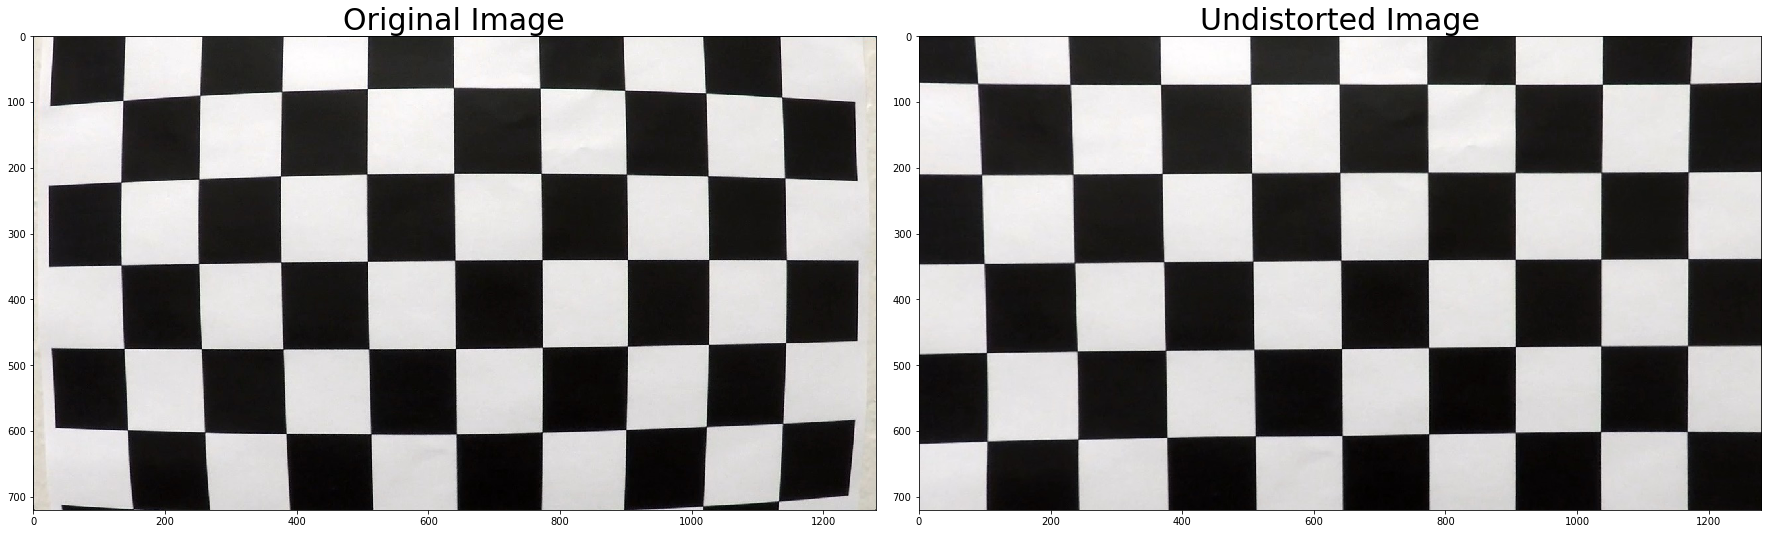

In [18]:
# Read in calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Read in calibration images
images = glob.glob('camera_cal/calibration*.jpg')

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

nx = 9
ny = 6

# Populate object points [0, 0, 0] , ... , [nx, ny, 0]
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates

for fname in images:

    # Read in the image file
    image = mpimg.imread(fname)

    # Convert to grayscale
    gray = grayscale(image)

    #plt.imshow(gray, cmap='gray')

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

# Calculate camera distortion
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Choose an image for validating camera correction
image = mpimg.imread(images[0])

# Undistort using camera distortion coefficients
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Plot Original and Undistorted Image for comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Thresholding on Images

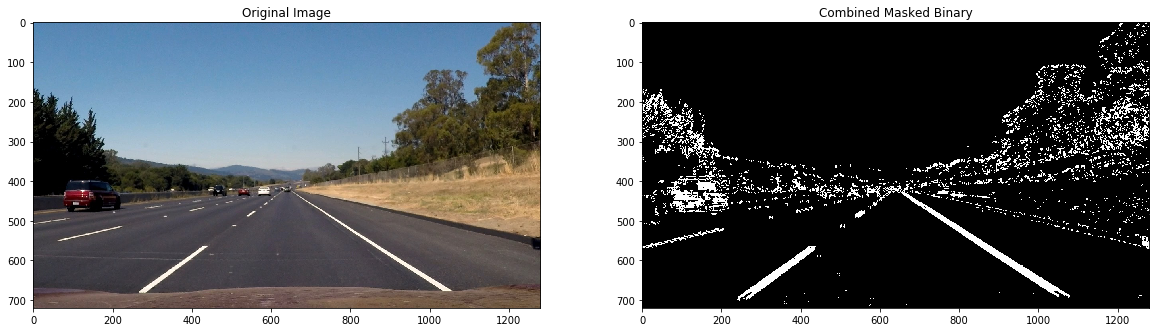

In [19]:
# Read in test image
image = mpimg.imread('test_images/straight_lines2.jpg')
#plt.imshow(image)

# Undistort
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Convert to grayscale
gray = grayscale(undist)
#plt.imshow(gray, cmap='gray')

# X Thresholding
gradx = sobel_thresh(gray, orient='x', sobel_kernel=15, thresh=(20, 200))
#plt.imshow(gradx, cmap='gray')

# Y Thresholding
grady = sobel_thresh(gray, orient='y', sobel_kernel=15, thresh=(20, 200))
#plt.imshow(grady, cmap='gray')

# Magnitude Thresholding
mag_bin = mag_thresh(gray, sobel_kernel=15, thresh=(30, 200))
#plt.imshow(mag_bin, cmap='gray')

# Direction Thresholding
dir_bin = dir_thresh(gray, sobel_kernel=15, thresh=(0.7, 1.3))
#plt.imshow(dir_bin, cmap='gray')

s_bin = hls_select(image, thresh=(150, 255))
#plt.imshow(s_bin, cmap='gray')

combined = np.zeros_like(dir_bin)
combined[((gradx == 1) & (grady == 1)) | ((mag_bin == 1) & (dir_bin == 1)) | (s_bin == 1)] = 1
#plt.imshow(combined, cmap='gray')

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(image)

ax2.set_title('Combined Masked Binary')
ax2.imshow(combined, cmap='gray')

### Perspective Transform

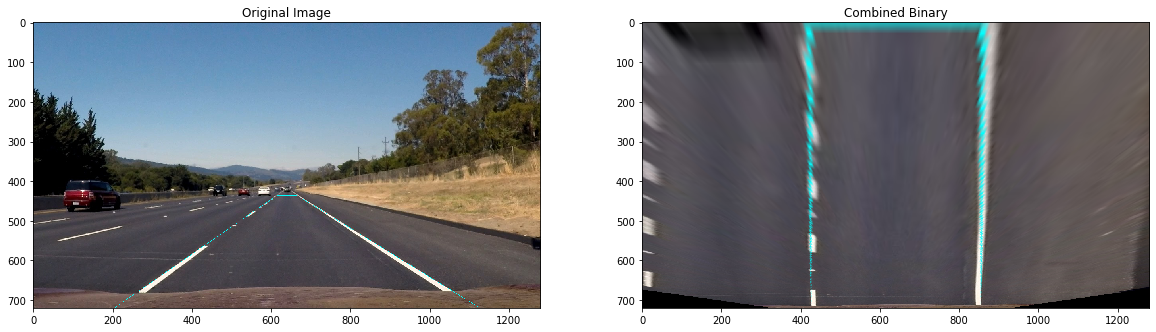

In [20]:
img_size = (image.shape[1], image.shape[0])

# Tune coefficients to capture perspective
x1 = np.int(0.16 * img_size[0])
x2 = np.int(0.48 * img_size[0])
x3 = np.int(0.52 * img_size[0])
x4 = np.int(0.88 * img_size[0])
x5 = np.int(1 / 3 * img_size[0])
x6 = np.int(2 / 3 * img_size[0])

horizon = img_size[1]/1.65

src = np.float32([[x1, img_size[1]], [x2, horizon], [x3, horizon], [x4, img_size[1]]])
dst = np.float32([[x5, img_size[1]], [x5, 0], [x6, 0], [x6, img_size[1]]])

pts = np.array([[x1, img_size[1]], [x2, horizon], [x3, horizon], [x4, img_size[1]]], np.int32)
pts = pts.reshape((-1, 1, 2))

# Get perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

image = cv2.polylines(image, [pts],True,(0, 255, 255))

# Warp image
image_warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

# Warp combined
binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(image)

ax2.set_title('Combined Binary')
ax2.imshow(image_warped, cmap='gray')

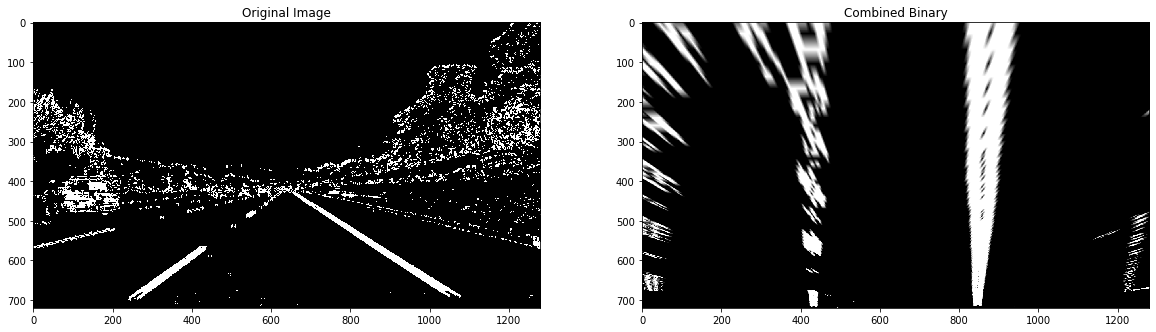

In [21]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(combined, cmap = 'gray')

ax2.set_title('Combined Binary')
ax2.imshow(binary_warped, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


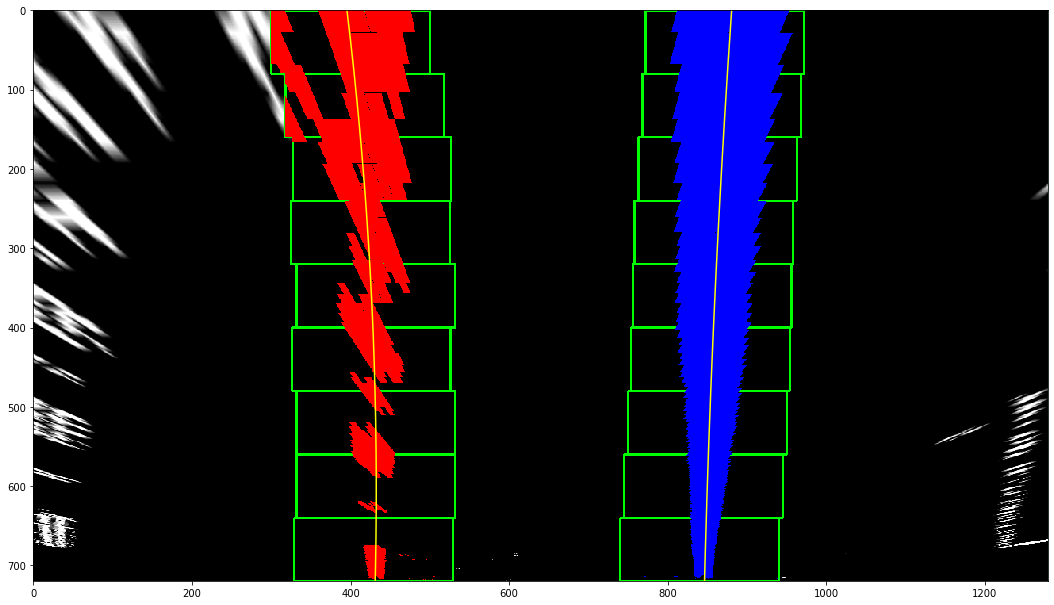

In [25]:
out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)